In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import DenseLayer
from janelia_core.ml.extra_torch_modules import DenseLNLNet
from janelia_core.visualization.matrix_visualization import cmp_n_mats

## Define helper functions

In [3]:
def produce_y_image(f, x_range = [0.0, 1.0], y_range = [0.0, 1.0], n_points_per_side=100):
    
    with torch.no_grad():
        grid = np.mgrid[x_range[0]:x_range[1]:n_points_per_side * 1j,
                        y_range[0]:y_range[1]:n_points_per_side * 1j]

        grid_vec = np.stack([np.ravel(grid[0, :, :]), np.ravel(grid[1, :, :])]).transpose()
        grid_vec = torch.from_numpy(grid_vec.astype('float32'))

        y = f(grid_vec).detach().numpy()
        y_image = np.reshape(y, [n_points_per_side, n_points_per_side])
    
        return y_image

## Create a target mapping we will try to learn and training data

In [4]:
def true_map(x, bump_ctrs, bump_mags, bump_stds):
    
    n_smps = x.shape[0]
    
    with torch.no_grad():
        y = torch.zeros([n_smps,1])
        
        
        for i in range(n_bumps):
            bump_ctr = bump_ctrs[i, :]
            bump_mag = bump_mags[i]
            bump_std = bump_stds[i, :]
    
            y_i = bump_mag*torch.exp(-1*torch.sum(((x - bump_ctr)/bump_std)**2,1))
            y += y_i.view([n_smps, 1])
            
        return y

In [46]:
# Create a target mapping w
n_bumps = 3

bump_ctrs = torch.zeros(n_bumps, 2)
bump_mags = torch.ones(n_bumps)
bump_stds = .5*torch.ones(n_bumps, 2)

for i in range(n_bumps):
    bump_ctrs[i,:] = torch.rand(2)

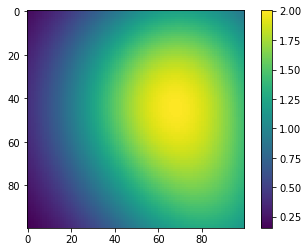

In [47]:
# Visualize target mapping
f_true = lambda x: true_map(x, bump_ctrs, bump_mags, bump_stds)
true_y = produce_y_image(f_true)
plt.imshow(true_y)
plt.colorbar()

## Generate sample points for training

In [48]:
n_smps = 5000
x = torch.rand([n_smps, 2])
y = f_true(x)

## Define network we will train

In [49]:
d_in = 5
n_layers = 40
growth_rate = 5

first_layer = torch.nn.Linear(in_features= 2, out_features=d_in, 
                              bias=True)

dn = DenseLNLNet(d_in=d_in, n_layers=n_layers, growth_rate=growth_rate, 
                 nl_class=torch.nn.Sigmoid, bias=False)

final_layer = torch.nn.Linear(in_features= d_in + n_layers*growth_rate, out_features=1, 
                              bias=False)

yn = torch.nn.Sequential(first_layer, dn, final_layer)

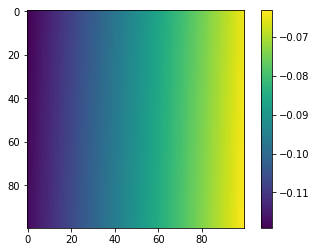

In [50]:
est_y = produce_y_image(yn)
plt.imshow(est_y)
plt.colorbar()

## Train the network

In [51]:
optimizer = torch.optim.Adam(yn.parameters(), lr=.001)

for i in range(1000):
    
    optimizer.zero_grad()
    er = torch.sum((y - yn(x))**2)
    er.backward()
    optimizer.step()
    
    er_r = er.detach().numpy()
    
    if i % 100 == 0:
        print('er: ' + str(er))
    
    

er: tensor(9999.3447, grad_fn=<SumBackward0>)
er: tensor(1056.4762, grad_fn=<SumBackward0>)
er: tensor(815.2792, grad_fn=<SumBackward0>)
er: tensor(513.7592, grad_fn=<SumBackward0>)
er: tensor(444.4456, grad_fn=<SumBackward0>)
er: tensor(441.1388, grad_fn=<SumBackward0>)
er: tensor(437.0871, grad_fn=<SumBackward0>)
er: tensor(431.2754, grad_fn=<SumBackward0>)


KeyboardInterrupt: 

## View results 

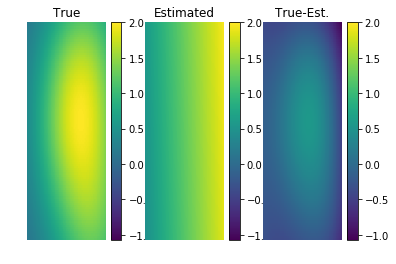

In [52]:
# Visualize target mapping
est_y = produce_y_image(yn)
axes = cmp_n_mats([true_y, est_y, true_y-est_y], 
           titles=['True', 'Estimated', 'True-Est.'],
           show_colorbars=True)